# Exploratory Data Analysis (EDA)

## Non-Image Data

Load the cleaned data...

In [1]:
import pandas as pd

In [2]:
data_path = "../clean_data/cleaned_data.csv"
data = pd.read_csv(data_path)

In [3]:
data

,img_idx,labels,age,gender,view_pos,img_w,img_h,img_pix_spc_x,img_pix_spc_y
0,00000001_000.png,Cardiomegaly,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...
112099,00030801_001.png,Mass|Pneumonia,39,M,PA,2048,2500,0.168,0.168
112100,00030802_000.png,No Finding,29,M,PA,2048,2500,0.168,0.168
112101,00030803_000.png,No Finding,42,F,PA,2048,2500,0.168,0.168
112102,00030804_000.png,No Finding,30,F,PA,2048,2500,0.168,0.168


Check data imbalanes and visualize the data.

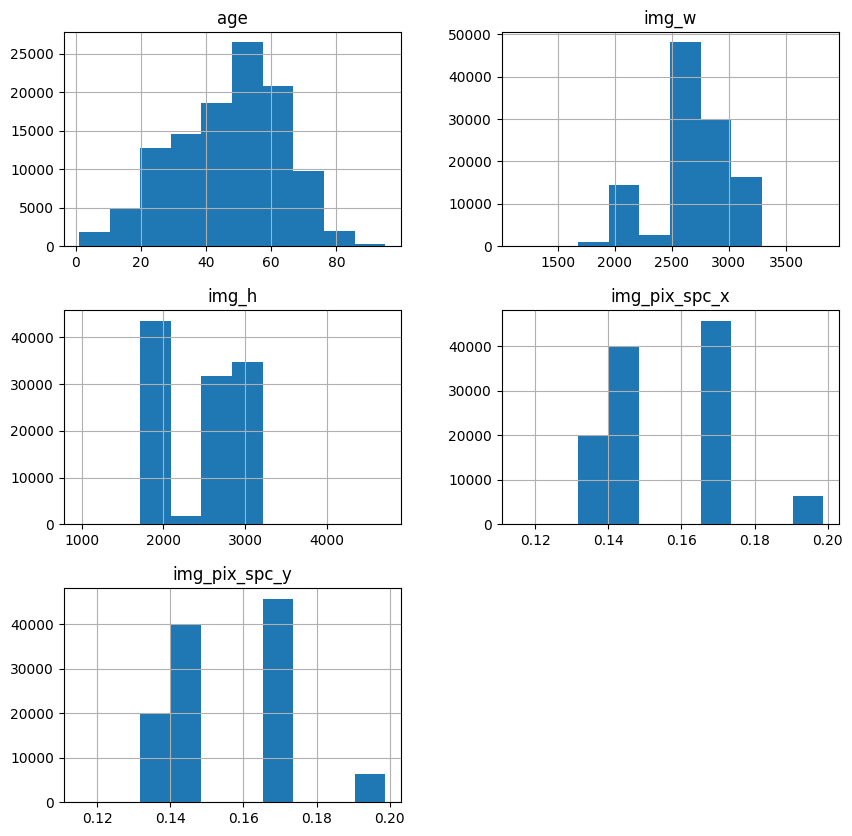

In [4]:
data.hist(figsize=(10, 10));

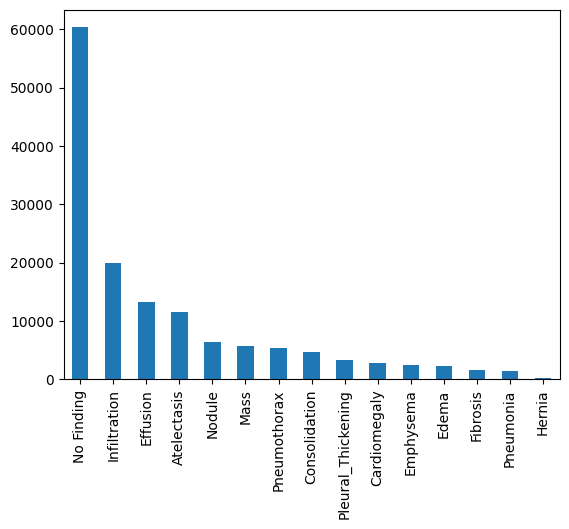

In [5]:
# Split labels based on a delimiter
data["labels"].str.split("|").explode("labels").value_counts().plot(kind="bar");

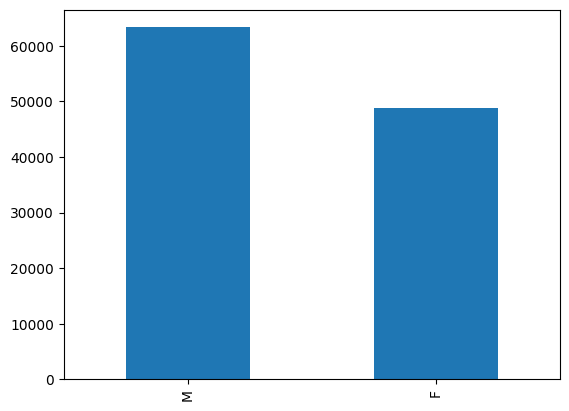

In [6]:
data["gender"].value_counts().plot(kind="bar");

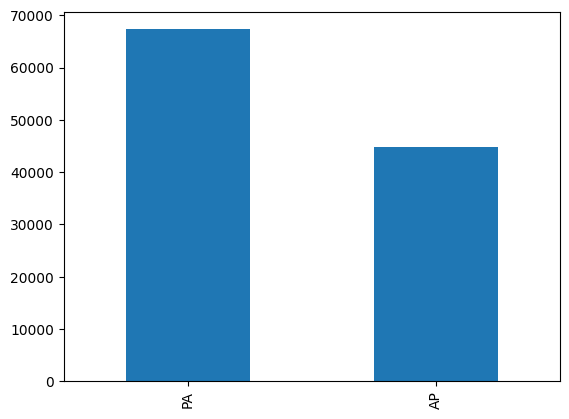

In [7]:
data["view_pos"].value_counts().plot(kind="bar");

In [8]:
labels_df = pd.DataFrame(data["labels"].str.split("|").explode("labels").value_counts())
labels_df

,labels
No Finding,60353
Infiltration,19891
Effusion,13316
Atelectasis,11558
Nodule,6331
Mass,5779
Pneumothorax,5301
Consolidation,4667
Pleural_Thickening,3384
Cardiomegaly,2776


How many total condition labels are there (including "no finding")?

In [9]:
labels_df.sum(axis=0)

labels    141517
dtype: int64

Of those, how many are the ones we "care about" for our project?

In [10]:
all_labels = list(
    pd.DataFrame(data["labels"].str.split("|").explode("labels")).labels.unique()
)

do_care_labels = [
    "Pneumonia",
    "Cardiomegaly",
    "Pleural_Thickening",
    "Consolidation",
    "Pneumothorax",
    "Effusion",
    "No Finding",
]
other_labels = [l for l in all_labels if l not in do_care_labels]

labels_df.filter(items=do_care_labels, axis=0).sum()

labels    91227
dtype: int64

In [11]:
other_labels_count = labels_df[~labels_df.index.isin(do_care_labels)].sum()
other_labels_count

labels    50290
dtype: int64

Let's look at the breakdown one more time...

In [12]:
labels_df.filter(
    items=do_care_labels,
    axis=0,
)

,labels
Pneumonia,1430
Cardiomegaly,2776
Pleural_Thickening,3384
Consolidation,4667
Pneumothorax,5301
Effusion,13316
No Finding,60353


And chart it...

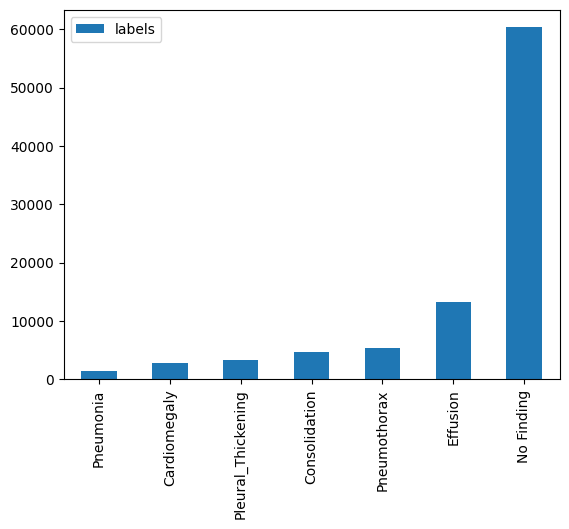

In [13]:
labels_df.filter(
    items=do_care_labels,
    axis=0,
).plot(kind="bar");

With all "other" labels aggregated...

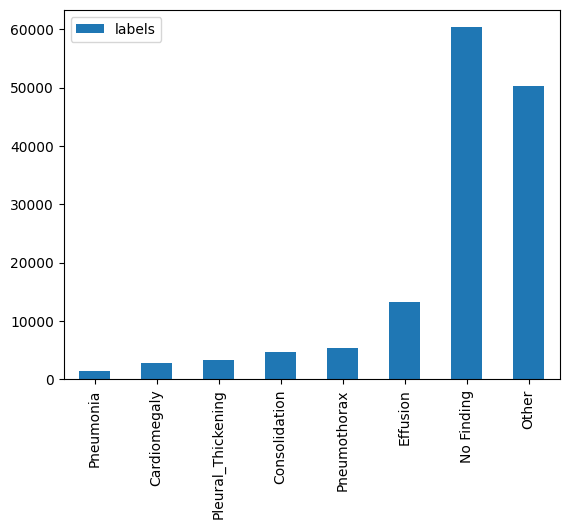

In [14]:
do_care_labels_df = labels_df.filter(
    items=do_care_labels,
    axis=0,
)

agg_other_labels_df = pd.concat(
    [do_care_labels_df, pd.DataFrame([other_labels_count], index=["Other"])], axis=0
)
agg_other_labels_df.plot(kind="bar");

Let's take a look at the unique combinations of the various conditions and their counts...

In [15]:
data[["labels"]].stack().droplevel(1).value_counts()

No Finding                                                         60353
Infiltration                                                        9546
Atelectasis                                                         4214
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia        1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax         1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                  1
Edema|Infiltration|Pneumothorax                                        1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax         1
Length: 836, dtype: int64

Multi-label Binary-Encode the labels (manually for now; in the future, we'll use a [`MultiLabelBinarizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) in our pipeline).

In [16]:
for l in all_labels:
    data[l] = data.labels.apply(lambda x: l in x)

In [24]:
data["Other"] = False
for l in other_labels:
    data["Other"] = data["Other"] | data[l]

In [25]:
data

,img_idx,labels,age,gender,view_pos,img_w,img_h,img_pix_spc_x,img_pix_spc_y,Cardiomegaly,...,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,Other
0,00000001_000.png,Cardiomegaly,58,M,PA,2682,2749,0.143,0.143,True,...,False,False,False,False,False,False,False,False,False,False
1,00000001_001.png,Cardiomegaly|Emphysema,58,M,PA,2894,2729,0.143,0.143,True,...,False,False,False,False,False,False,False,False,False,True
2,00000001_002.png,Cardiomegaly|Effusion,58,M,PA,2500,2048,0.168,0.168,True,...,False,False,False,False,False,False,False,False,False,False
3,00000002_000.png,No Finding,81,M,PA,2500,2048,0.171,0.171,False,...,False,False,False,False,False,False,False,False,False,False
4,00000003_000.png,Hernia,81,F,PA,2582,2991,0.143,0.143,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112099,00030801_001.png,Mass|Pneumonia,39,M,PA,2048,2500,0.168,0.168,False,...,True,False,False,False,False,True,False,False,False,True
112100,00030802_000.png,No Finding,29,M,PA,2048,2500,0.168,0.168,False,...,False,False,False,False,False,False,False,False,False,False
112101,00030803_000.png,No Finding,42,F,PA,2048,2500,0.168,0.168,False,...,False,False,False,False,False,False,False,False,False,False
112102,00030804_000.png,No Finding,30,F,PA,2048,2500,0.168,0.168,False,...,False,False,False,False,False,False,False,False,False,False


In [32]:
data.drop(columns=other_labels, inplace=True)
for l in do_care_labels + ["Other"]:
    data.rename(columns={l: "label_"+l.lower().replace(" ", "_")}, inplace=True)
data

,img_idx,labels,age,gender,view_pos,img_w,img_h,img_pix_spc_x,img_pix_spc_y,label_cardiomegaly,label_effusion,label_no_finding,label_pneumothorax,label_pleural_thickening,label_pneumonia,label_consolidation,label_other
0,00000001_000.png,Cardiomegaly,58,M,PA,2682,2749,0.143,0.143,True,False,False,False,False,False,False,False
1,00000001_001.png,Cardiomegaly|Emphysema,58,M,PA,2894,2729,0.143,0.143,True,False,False,False,False,False,False,True
2,00000001_002.png,Cardiomegaly|Effusion,58,M,PA,2500,2048,0.168,0.168,True,True,False,False,False,False,False,False
3,00000002_000.png,No Finding,81,M,PA,2500,2048,0.171,0.171,False,False,True,False,False,False,False,False
4,00000003_000.png,Hernia,81,F,PA,2582,2991,0.143,0.143,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112099,00030801_001.png,Mass|Pneumonia,39,M,PA,2048,2500,0.168,0.168,False,False,False,False,False,True,False,True
112100,00030802_000.png,No Finding,29,M,PA,2048,2500,0.168,0.168,False,False,True,False,False,False,False,False
112101,00030803_000.png,No Finding,42,F,PA,2048,2500,0.168,0.168,False,False,True,False,False,False,False,False
112102,00030804_000.png,No Finding,30,F,PA,2048,2500,0.168,0.168,False,False,True,False,False,False,False,False


## Image Data

Test out loading images from file names...

In [19]:
import os
import pathlib

# import PIL
import PIL.Image

In [20]:
cwd = os.getcwd()
data_dir = pathlib.Path(cwd, "..", "raw_data", "temp_img")

In [21]:
# cwd = os.getcwd()
# data_dir = pathlib.Path(cwd)
data_dir = pathlib.Path("../raw_data/temp_img")
data_dir

PosixPath('../raw_data/temp_img')

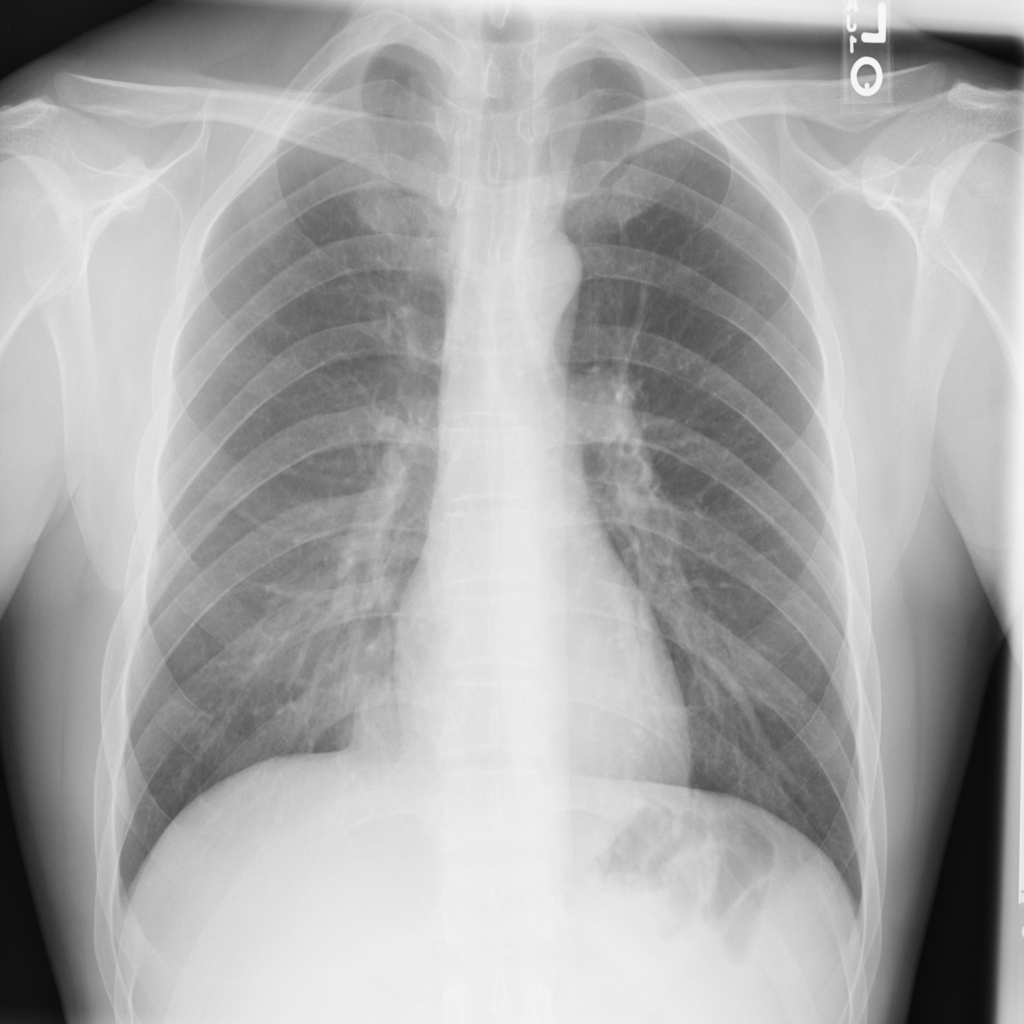

In [22]:
# PIL.Image.open(pathlib.Path(data_dir, "00030805_000.png"))

xray_images = list(data_dir.glob("*.png"))
PIL.Image.open(xray_images[0])

# Baseline Model